In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple

import gym
import numpy as np
import time
import cv2

import random
import math
from itertools import count


from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Checking the Environment

In [2]:
env_id = 'CartPole-v0'

env = gym.make(env_id)
env.reset()
# for _ in range(400):
#     env.render()
#     time.sleep(0.01)
#     env.step(env.action_space.sample())   # take random actions
# env.close()

array([-0.01334107, -0.03290919,  0.02486646, -0.02966823])

Checking and using if CUDA is available()

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Experience Replay to have memory for model

In [4]:
from collections import deque

class exp_replay(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [5]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 3000
gamma = 0.999
batch_size = 128

replay_buffer_size = 10000
learning_rate = 0.0001
num_episodes = 500
target_update_freq = 10


In [6]:
def get_cart_loc(screen_width):
    world_width = env.x_threshold*2
    scale = screen_width/world_width
#     print(scale)
#     print(int(env.state[0]*scale + screen_width/2.0))
    return int(env.state[0]*scale + screen_width/2.0)

In [7]:
# def get_screen():
#         screen = env.render(mode='rgb_array')
#         screen_1 = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
#         r_screen = cv2.resize(screen_1, (84,84), interpolation=cv2.INTER_AREA)
#         r_screen = np.array(r_screen)
#         r_screen = np.expand_dims(r_screen,axis=0)
#         r_screen = torch.Tensor(r_screen)
#         return r_screen.unsqueeze(0).to(device)


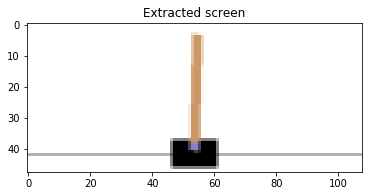

In [8]:
def get_screen():
    screen = env.render(mode = 'rgb_array')
    ### Capture screen return in shape (H,W,C) = (400,600,3)
    
    ### Cart is in lower half of screen. We remove the unuseful part of environment
    screen_height, screen_width, _ = screen.shape
    screen = screen[int(screen_height*0.4):int(screen_height*0.8),:]  # Screen Shape is now (160,600,3)
#     print(screen.shape)

    view_width = int(screen_width*0.6) # width required when pole becomes horizontal. 
#     print(view_width//2)
    cart_loc = get_cart_loc(screen_width)

    ### Extract screen where cart is locaed and discard the remaining part
    if cart_loc < view_width//2:
        slice_range = slice(view_width)
    elif cart_loc > (screen_width - view_width//2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_loc - view_width//2, cart_loc + view_width//2)
#     print(slice_range)
    screen = screen[:,slice_range,:]
#     print(screen.shape)
    
    width = int(screen.shape[1] * 30 / 100)
    height = int(screen.shape[0] * 30 / 100)
    dim = (width, height)
#     print(dim)
    # resize image
    screen = cv2.resize(screen, dim, interpolation = cv2.INTER_AREA)
#     print(screen.shape)
    ### Pytorch work wwith format (C,H,W). So we take transpose
    screen = screen.transpose((2,0,1))
#     
    
    ### Convert ot float and normalize
    screen = np.ascontiguousarray(screen, dtype = np.float32)/255
    screen=np.expand_dims(screen,0)
    
    ### Convert to tensor
    screen = torch.from_numpy(screen)
#     print(screen.shape)
    return screen
    

### Image appears to be blur due to interpolation
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title('Extracted screen')
plt.show()

Deep Q-Network

In [9]:
class dqn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(dqn, self).__init__()
        self.device='cuda' if torch.cuda.is_available() else 'cpu'
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
    def forward(self, x):
        x=x.to(self.device)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)

In [10]:
init_screen = get_screen()
init_screen = init_screen.squeeze(0)
# print(init_screen.shape[2])


num_actions = env.action_space.n
policy_net = dqn(init_screen.shape, num_actions).to(device)
target_net = dqn(init_screen.shape, num_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

criterion = nn.MSELoss()
optimizer = optim.Adam(policy_net.parameters())

memory = exp_replay(10000)

In [11]:
steps_done = 0
def select_action(state, epsilon):
    global steps_done
    sample = random.random()

    if sample < epsilon:
        action = random.randrange(env.action_space.n)    
    else:
        q_val = policy_net(state)
        action = torch.argmax(q_val).item()
            
    return action


def plot_durations(scores,pause):
    plt.ion()
    plt.figure(2)
    plt.clf()

    durations_t = torch.tensor(scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Scores')
    plt.plot(durations_t.numpy())
    # Take 20 episode averages and plot them too
    if len(durations_t) >= 20:
        means = durations_t.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy())
    if pause< 25:
        plt.pause(pause)  # pause a bit so that plots are updated
        if is_ipython:
            display.clear_output(wait=True)
            display.display(plt.gcf())

In [12]:
def learn():
    if len(memory) < batch_size:
        return
    
    
    state, action, reward, next_state, done = memory.sample(batch_size)
    
    
    state=torch.FloatTensor(state)
    action=torch.tensor(action).to(device)
    reward=torch.tensor(reward).to(device)
    next_state=torch.FloatTensor(next_state)
    done=torch.tensor(done).float().to(device)
    
    
    
#     state_batch, action_batch, reward_batch, next_state_batch, done_batch = memory.sample(batch_size)
#     reward_batch = torch.tensor(reward_batch, device = device)
#     done_batch = torch.tensor(done_batch, device = device)
# #     print(done_batch)
#     action_batch = torch.tensor(action_batch,device = device)
# #     print(action_batch.size())
#     done_batch = torch.tensor(done, device = device, dtype = torch.float)
# #     print(done_batch)

    q_vals = policy_net(state)
    q_next = target_net(next_state).detach()
# #     print(q_val.size, q_target.size)
#     batch_index = np.arange(batch_size)
    q_val = q_vals.gather(1, action.unsqueeze(1)).squeeze(1)
    q_next_val = q_next.max(1)[0]
    

    expected_q_val = reward + gamma*q_next_val*(1-done)
    
    loss = criterion(q_val, expected_q_val)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
ep_reward = []
num_frame = 120


epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon - epsilon_min) * math.exp(-1. * frame_idx / epsilon_decay)



steps = 0
for ep in range(1, num_frame+1):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    done = 0
    total_reward  = 0
    while not done:
        
        epsilon = epsilon_by_frame(steps)
        steps += 1
        
        action = select_action(state, epsilon)
        
        _, reward, done, _ = env.step(action)
#         next_state = torch.tensor(next_state, device = device, dtype = torch.float)
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        next_state = current_screen - last_screen
        
        
        memory.push(state, action, reward, next_state, done)
        loss = learn()     # Learning of model with help of experience replay
        
        total_reward += reward
        state = next_state

        
    ep_reward.append(total_reward)
    # Update the target network, copying all weights and biases in DQN
    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
        plot_durations(ep_reward,2)
print('Complete')
env.close()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

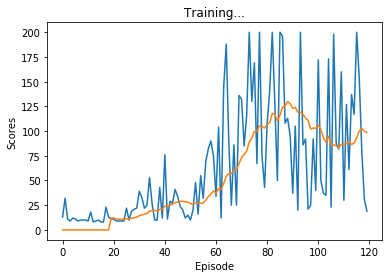

In [14]:
plot_durations(ep_reward,25)